In [1]:
import sys, os
sys.path.append("/Users/1nao/GitHub/BayesML-alpha")

import numpy as np
import os
from bayesml import metatree
from bayesml import normal
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from collections import Counter
import pathlib
from copy import deepcopy

In [2]:
SEED = 0
rng = np.random.default_rng(SEED)
np.random.seed(SEED)
MODEL_SEED = 0 # Seed for the learnmodel

In [3]:
FILE_DIR = pathlib.Path().resolve() / 'metatree_experiment_code' / '2501_gb_nexttree'
FIG_DIR = pathlib.Path().resolve() / 'metatree_experiment_code' / '2501_gb_nexttree' / 'fig'
TREE_FIG_DIR = FIG_DIR / 'tree'
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TREE_FIG_DIR, exist_ok=True)

# ベンチマークデータ読み込み

In [4]:
DIR_DATA = '/Users/1nao/GitHub/metatree_experiments/regression/preprocessed_data'
# フォルダ名一覧から全データ名を取得
DATA_NAMES = os.listdir(DIR_DATA)
DATA_NAMES = np.sort([d for d in DATA_NAMES if d != '.DS_Store'])
DATA_NAMES = [data_name for data_name in DATA_NAMES if data_name != 'california'] + ['california'] # californiaはデータ数多く重いので最後に
DATA_NAMES

['Mpg',
 'abalone',
 'ais',
 'automobile',
 'baseball',
 'baskball',
 'boston',
 'budget',
 'cps',
 'cpu',
 'diabetes',
 'diamond',
 'liver',
 'ozone',
 'ozone_spss',
 'servo',
 'strikes',
 'student',
 'wine_quality',
 'california']

## データの読み込み

## 関数の定義

In [5]:
def load_data(
        data_name: str,
        dir_data: str=DIR_DATA,
        flag_lr: bool = False,
):
    # 個人の環境でpathを変更
    X_continuous_load = np.load(os.path.join(dir_data,data_name,'x_continuous.npy'))
    X_categorical = np.load(os.path.join(dir_data,data_name,'x_categorical.npy')).astype(int)
    y = np.load(os.path.join(dir_data,data_name,'y.npy'))

    # 連続説明変数の標準化
    mean = np.mean(X_continuous_load,axis=0)
    std = np.std(X_continuous_load,axis=0)
    X_continuous = (X_continuous_load - mean) / std

    # 線形回帰で定数項を入れる処理
    if flag_lr:
        tmp = np.copy(X_continuous)
        X_continuous = np.ones([tmp.shape[0],tmp.shape[1]+1])
        X_continuous[:,:-1] = tmp

    #標準化の処理
    y = (y - y.mean()) / y.std()

    return X_continuous, X_categorical, y

In [6]:
data_name = 'california'

In [7]:
x_continuous,x_categorical,y = load_data(data_name,DIR_DATA)
x_continuous.shape, x_categorical.shape, y.shape

((20640, 8), (20640, 0), (20640,))

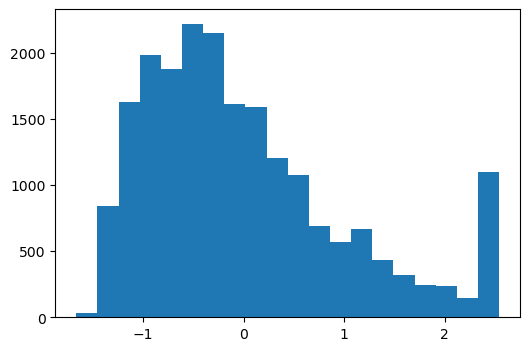

In [8]:
plt.figure(figsize=(6, 4))
plt.hist(y, bins=20, alpha=1, label='y')
plt.show()

In [9]:
# すべてのデータのサンプル数と説明変数の数を確認
for data_name in DATA_NAMES:
    x_continuous,x_categorical,y = load_data(data_name,DIR_DATA)
    print(data_name, x_continuous.shape[0], x_continuous.shape[1] + x_categorical.shape[1])

Mpg 392 11
abalone 4177 10
ais 202 21
automobile 159 57
baseball 263 90
baskball 96 4
boston 506 13
budget 1729 10
cps 534 19
cpu 209 36
diabetes 442 10
diamond 308 15
liver 345 5
ozone 330 8
ozone_spss 330 6
servo 167 12
strikes 625 22
student 395 43
wine_quality 4898 11
california 20640 8


## 学習と指標計算を行う関数作成

In [10]:
# 関数の定義順の都合上木の数をここで指定
num_tree = 100

In [11]:
filepath = pathlib.Path().resolve() / 'metatree_experiment_code' / '241225_singletree_depth_analysis'
sys.path.append(str(filepath))
# from generate_assignment import generate_random_assignments_with_fixed
# from metatree_hit_metrics import calc_chi
from sklearn.metrics import mean_squared_error
from scipy.stats import sem

In [12]:
sub_h_params_learnmodel = {
    'h0_tau_x': 1e1,
    'h0_m': 0.,
    'h0_tau': 1e0,
    'known_precision': True,
}
max_depth = 5
h0_split = 0.8
learning_rate = 0.5

In [13]:
MT_model_dict = {
    'model': metatree.MetaTreeLearnModel,
    'model_type': 'metatree',
    'init_params': {
        'SubModel': normal,
        'sub_h0_params': sub_h_params_learnmodel, # same to true-generative model
        'c_max_depth': max_depth,
        'h0_split': h0_split,
        'seed': MODEL_SEED,
    },
    'build_params': {
        'split_strategy': 'best',
        'criterion': 'squared_error_leaf',
        'building_scheme': 'depth_first',
    }
}

In [14]:
MTCART_model_dict = {
    'model': metatree.MetaTreeLearnModel,
    'model_type': 'metatree',
    'init_params': {
        'SubModel': normal,
        'sub_h0_params': sub_h_params_learnmodel, # same to true-generative model
        'c_max_depth': max_depth,
        'h0_split': h0_split,
        'seed': MODEL_SEED,
    },
    'build_params': {
        'split_strategy': 'copy_from_sklearn_tree',
        'criterion': 'squared_error_leaf',
        # 'building_scheme': 'depth_first',
    }
}

In [15]:
DT_model_dict = {
    'model': metatree.MetaTreeLearnModel,
    'model_type': 'metatree',
    'init_params': {
        'SubModel': normal,
        'sub_h0_params': sub_h_params_learnmodel, # same to true-generative model
        'c_max_depth': max_depth,
        'h0_split': 1.,
        'seed': MODEL_SEED,
    },
    'build_params': {
        'split_strategy': 'best',
        'criterion': 'squared_error_leaf',
        'building_scheme': 'depth_first',
    }
}

In [16]:
DTCART_model_dict = {
    'model': metatree.MetaTreeLearnModel,
    'model_type': 'metatree',
    'init_params': {
        'SubModel': normal,
        'sub_h0_params': sub_h_params_learnmodel, # same to true-generative model
        'c_max_depth': max_depth,
        'h0_split': 1.,
        'seed': MODEL_SEED,
    },
    'build_params': {
        'split_strategy': 'copy_from_sklearn_tree',
        'criterion': 'squared_error_leaf',
        # 'building_scheme': 'depth_first',
    }
}

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
GB_METAIZATION_model_dict = {
    'model': metatree.SumOfMetaTreeLearnModel,
    'model_type': 'metatree',
    'init_params': {
        'c_num_metatrees': num_tree,
        'SubModel': normal,
        'sub_h0_params': sub_h_params_learnmodel, # same to true-generative model
        'c_max_depth': max_depth,
        'h0_split': h0_split,
        'learning_rate': learning_rate,
        'seed': MODEL_SEED,
    },
    'build_params': {
        'split_strategy': 'copy_sklearn_ensemble',
        'calc_residual': False,
        'SklearnEnsembleObj': GradientBoostingRegressor,
        'params_sklearn_ensemble': {
            'n_estimators': num_tree,
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'random_state': MODEL_SEED,
        },
        'update_leaf_with_residual': True,
    }
}

In [18]:
MTGB_model_dict = {
    'model': metatree.SumOfMetaTreeLearnModel,
    'model_type': 'metatree',
    'init_params': {
        'c_num_metatrees': num_tree,
        'SubModel': normal,
        'sub_h0_params': sub_h_params_learnmodel,
        'c_max_depth': max_depth,
        'h0_split': h0_split,
        'learning_rate': learning_rate,
        'seed': MODEL_SEED,
    },
    'build_params': {
        'split_strategy': 'best',
        'building_scheme': 'depth_first',
        'calc_residual': True,
    }
}

## Define functions

In [19]:
from sklearn.tree import DecisionTreeRegressor
def learn_predict_manual_gb(
        x_continuous_train, x_categorical_train, y_train,
        x_continuous_test, x_categorical_test, y_test,
        num_tree,
        do_metatree: int, # 1: MT for all trees, 0: DT for the last tree, -1: DT for all trees
):
        data_info = {
                'c_dim_continuous': x_continuous_train.shape[1],
                'c_dim_categorical': x_categorical_train.shape[1],
        }
        tree_list = [None for _ in range(num_tree)]
        hat_y_train_list = [None for _ in range(num_tree)]
        hat_y_test_list = [None for _ in range(num_tree)]
        residual_train = deepcopy(y_train)
        for i in range(num_tree):
                if do_metatree==0:
                        if i == num_tree - 1:
                                model_dict = DT_model_dict
                                # model_dict = DTCART_model_dict
                        else:
                                model_dict = MT_model_dict
                                # model_dict = MTCART_model_dict
                if do_metatree==1:
                        model_dict = MT_model_dict
                        # model_dict = MTCART_model_dict
                if do_metatree==-1:
                        model_dict = DT_model_dict
                        # model_dict = DTCART_model_dict
                init_inputs = {
                        **model_dict['init_params'],
                        **data_info,
                }
                input_data = {
                        'x_continuous_vecs': x_continuous_train,
                        'x_categorical_vecs': x_categorical_train,
                        'y_vec': residual_train,
                }
                input_tree = {
                        'sklearn_tree': DecisionTreeRegressor(
                                max_depth=model_dict['init_params']['c_max_depth'],
                                random_state=SEED,
                        ),
                }
                input_tree['sklearn_tree'].fit(
                        np.concatenate([x_continuous_train, x_categorical_train], axis=1),
                        residual_train,
                )
                build_inputs = {
                        **model_dict['build_params'],
                        **input_tree,
                        **input_data,
                }
                model = model_dict['model'](**init_inputs)
                model.build(**build_inputs)
                model.calc_pred_dist()
                tree_list[i] = model

                hat_y_train_list[i] = model.make_prediction(
                        x_continuous_train,
                        x_categorical_train,
                        loss='squared',
                )
                hat_y_test_list[i] = model.make_prediction(
                        x_continuous_test,
                        x_categorical_test,
                        loss='squared',
                )
                residual_train -= hat_y_train_list[i] * learning_rate
        hat_y_train = np.sum(np.array(hat_y_train_list), axis=0) * learning_rate       
        hat_y_test = np.sum(np.array(hat_y_test_list), axis=0) * learning_rate
        return hat_y_train, hat_y_test, tree_list

In [20]:
from sklearn.tree import DecisionTreeRegressor
def learn_predict(
        x_continuous_train, x_categorical_train, y_train,
        x_continuous_test, x_categorical_test, y_test,
        num_tree,
        do_metatree: int, # 1: MT for all trees, 0: DT for the last tree, -1: DT for all trees(GradientBoostingRegressor)
):
        data_info = {
                'c_dim_continuous': x_continuous_train.shape[1],
                'c_dim_categorical': x_categorical_train.shape[1],
        }
        tree_list = [None for _ in range(num_tree)]
        hat_y_train_list = [None for _ in range(num_tree)]
        hat_y_test_list = [None for _ in range(num_tree)]
        residual_train = deepcopy(y_train)
        for i in range(num_tree):
                if do_metatree==0:
                        if i == num_tree - 1:
                                model_dict = DT_model_dict
                                # model_dict = DTCART_model_dict
                        else:
                                model_dict = MT_model_dict
                                # model_dict = MTCART_model_dict
                if do_metatree==1:
                        model_dict = MT_model_dict
                        # model_dict = MTCART_model_dict
                if do_metatree==-1:
                        model_dict = DT_model_dict
                        # model_dict = DTCART_model_dict
                init_inputs = {
                        **model_dict['init_params'],
                        **data_info,
                }
                input_data = {
                        'x_continuous_vecs': x_continuous_train,
                        'x_categorical_vecs': x_categorical_train,
                        'y_vec': residual_train,
                }
                input_tree = {
                        'sklearn_tree': DecisionTreeRegressor(
                                max_depth=model_dict['init_params']['c_max_depth'],
                                random_state=SEED,
                        ),
                }
                input_tree['sklearn_tree'].fit(
                        np.concatenate([x_continuous_train, x_categorical_train], axis=1),
                        residual_train,
                )
                build_inputs = {
                        **model_dict['build_params'],
                        **input_tree,
                        **input_data,
                }
                model = model_dict['model'](**init_inputs)
                model.build(**build_inputs)
                model.calc_pred_dist()
                tree_list[i] = model

                hat_y_train_list[i] = model.make_prediction(
                        x_continuous_train,
                        x_categorical_train,
                        loss='squared',
                )
                hat_y_test_list[i] = model.make_prediction(
                        x_continuous_test,
                        x_categorical_test,
                        loss='squared',
                )
                residual_train -= hat_y_train_list[i] * learning_rate
        hat_y_train = np.sum(np.array(hat_y_train_list), axis=0) * learning_rate       
        hat_y_test = np.sum(np.array(hat_y_test_list), axis=0) * learning_rate
        return hat_y_train, hat_y_test, tree_list

In [21]:
def learn_and_predict(
        x_continuous_train, x_categorical_train, y_train,
        x_continuous_test, x_categorical_test, y_test,
        data_roop_id,
        num_tree,
        do_metatree,
        visualize,
):
        hat_y_train, hat_y_test, tree_list = learn_predict_manual_gb(
                x_continuous_train, x_categorical_train, y_train,
                x_continuous_test, x_categorical_test, y_test,
                num_tree,
                do_metatree=do_metatree,
        )

        if visualize:
                for i, learntree in enumerate(tree_list):
                        tree_graph, _ = learntree.visualize_model(
                                view=False,
                        )
                        tree_graph.render(TREE_FIG_DIR / f'learntree_data{data_roop_id}_tree{i}_maxdepth{max_depth}_h0split{h0_split}', format='png', cleanup=True)

        return hat_y_train, hat_y_test, tree_list

In [22]:
def pred_measure_performance(
        x_continuous_train, x_categorical_train, y_train,
        x_continuous_test, x_categorical_test, y_test,
        data_roop_id,
        num_tree,
        do_metatree,
        visualize,
):
    hat_y_train, hat_y_test, tree_list = learn_and_predict(
        x_continuous_train, x_categorical_train, y_train,
        x_continuous_test, x_categorical_test, y_test,
        data_roop_id=data_roop_id,
        num_tree=num_tree,
        do_metatree=do_metatree,
        visualize=visualize,
    )
    train_mse = mean_squared_error(y_train, hat_y_train)
    test_mse = mean_squared_error(y_test, hat_y_test)
    return train_mse, test_mse

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
def pred_measure_performance_gb(
        x_continuous_train, x_categorical_train, y_train,
        x_continuous_test, x_categorical_test, y_test,
        num_tree,
):
    x_train = np.concatenate([x_continuous_train, x_categorical_train], axis=1)
    x_test = np.concatenate([x_continuous_test, x_categorical_test], axis=1)

    gb = GradientBoostingRegressor(n_estimators=num_tree, learning_rate=learning_rate, max_depth=max_depth, random_state=MODEL_SEED)
    gb.fit(x_train, y_train)
    hat_y_train = gb.predict(x_train)
    hat_y_test = gb.predict(x_test)

    train_mse = mean_squared_error(y_train, hat_y_train)
    test_mse = mean_squared_error(y_test, hat_y_test)
    return train_mse, test_mse

In [24]:
def pred_measure_performance_mtgb(
        x_continuous_train, x_categorical_train, y_train,
        x_continuous_test, x_categorical_test, y_test,
        num_tree,
):
        data_info = {
                'c_dim_continuous': x_continuous_train.shape[1],
                'c_dim_categorical': x_categorical_train.shape[1],
        }
        init_inputs = {
                **MTGB_model_dict['init_params'],
                **data_info,
        }

        build_inputs = {
                **MTGB_model_dict['build_params'],
                'x_continuous_vecs': x_continuous_train,
                'x_categorical_vecs': x_categorical_train,
                'y_vec': y_train,
        }
        model = MTGB_model_dict['model'](**init_inputs)
        model.build_metatrees(**build_inputs)
        # model.calc_pred_dist()

        hat_y_train = model.make_prediction(
                x_continuous_train,
                x_categorical_train,
                loss='squared',
        )
        hat_y_test = model.make_prediction(
                x_continuous_test,
                x_categorical_test,
                loss='squared',
        )

        train_mse = mean_squared_error(y_train, hat_y_train)
        test_mse = mean_squared_error(y_test, hat_y_test)
        
        root_split_proba_list = [None for _ in model.hn_metatree_list]
        for i, metatree in enumerate(model.hn_metatree_list):
                root_split_proba_list[i] = metatree.root_node.hn_split

        return train_mse, test_mse, root_split_proba_list

In [25]:

def pred_measure_performance_gb_metaization(
        x_continuous_train, x_categorical_train, y_train,
        x_continuous_test, x_categorical_test, y_test,
        num_tree,
):
        data_info = {
                'c_dim_continuous': x_continuous_train.shape[1],
                'c_dim_categorical': x_categorical_train.shape[1],
        }
        init_inputs = {
                **GB_METAIZATION_model_dict['init_params'],
                **data_info,
        }

        build_inputs = {
                **GB_METAIZATION_model_dict['build_params'],
                'x_continuous_vecs': x_continuous_train,
                'x_categorical_vecs': x_categorical_train,
                'y_vec': y_train,
        }
        model = GB_METAIZATION_model_dict['model'](**init_inputs)
        model.build_metatrees(**build_inputs)
        # model.calc_pred_dist()

        hat_y_train = model.make_prediction(
                x_continuous_train,
                x_categorical_train,
                loss='squared',
        )
        hat_y_test = model.make_prediction(
                x_continuous_test,
                x_categorical_test,
                loss='squared',
        )

        train_mse = mean_squared_error(y_train, hat_y_train)
        test_mse = mean_squared_error(y_test, hat_y_test)

        root_split_proba_list = [None for _ in model.hn_metatree_list]
        for i, metatree in enumerate(model.hn_metatree_list):
                root_split_proba_list[i] = metatree.root_node.hn_split

        return train_mse, test_mse, root_split_proba_list

In [26]:
ERROR_ARR_SAVE_DIR = FILE_DIR / 'error_array'
os.makedirs(ERROR_ARR_SAVE_DIR, exist_ok=True)

from sklearn.model_selection import KFold
def roop_kfold(
        data_name,
        num_tree,
        modelname,
        # do_metatree,
        visualize,
        num_cv=3,
        num_folds=5,
):
        num_trials = num_cv * num_folds
        x_continuous,x_categorical,y = load_data(data_name,DIR_DATA)
        
        # load mse list from ERROR_ARR_SAVE_DIR
        # try:
        #         train_mse_list = list(np.load(ERROR_ARR_SAVE_DIR / f'{data_name}_{modelname}_train_mse.npy'))
        #         test_mse_list = list(np.load(ERROR_ARR_SAVE_DIR / f'{data_name}_{modelname}_test_mse.npy'))
        # except:
        #         # tqdm.write(f'No file found. Create new list.')
        #         train_mse_list = []
        #         test_mse_list = []
        train_mse_list = []
        test_mse_list = []
        if modelname in ['MTGB', 'GB_metaization']:
                root_split_proba_list_list = []

        with tqdm(total=num_cv, desc=f'{num_cv}CV', leave=False) as bar1:
                for i in range(num_cv):
                        with tqdm(total=num_folds, desc=f'{num_folds} folds', leave=False) as bar2:
                                kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED+i)
                                for j, (train_index, test_index) in enumerate(kf.split(y)):
                                        x_continuous_train, x_continuous_test = x_continuous[train_index], x_continuous[test_index]
                                        x_categorical_train, x_categorical_test = x_categorical[train_index], x_categorical[test_index]
                                        y_train, y_test = y[train_index], y[test_index]
                                        if modelname == 'MT':
                                                do_metatree = 1
                                        elif modelname == 'last_DT':
                                                do_metatree = 0
                                        elif modelname == 'all_DT':
                                                do_metatree = -1
                                        elif modelname == 'GB':
                                                train_mse, test_mse = pred_measure_performance_gb(
                                                        x_continuous_train, x_categorical_train, y_train,
                                                        x_continuous_test, x_categorical_test, y_test,
                                                        num_tree=num_tree,
                                                )
                                                train_mse_list.append(train_mse)
                                                test_mse_list.append(test_mse)
                                                bar2.update(1)
                                                continue
                                        elif modelname == 'GB_metaization':
                                                train_mse, test_mse, root_split_proba_list = pred_measure_performance_gb_metaization(
                                                        x_continuous_train, x_categorical_train, y_train,
                                                        x_continuous_test, x_categorical_test, y_test,
                                                        num_tree=num_tree,
                                                )
                                                train_mse_list.append(train_mse)
                                                test_mse_list.append(test_mse)
                                                bar2.update(1)
                                                continue
                                        elif modelname == 'MTGB':
                                                train_mse, test_mse, root_split_proba_list = pred_measure_performance_mtgb(
                                                        x_continuous_train, x_categorical_train, y_train,
                                                        x_continuous_test, x_categorical_test, y_test,
                                                        num_tree=num_tree,
                                                )
                                                train_mse_list.append(train_mse)
                                                test_mse_list.append(test_mse)
                                                root_split_proba_list_list.append(root_split_proba_list)
                                                bar2.update(1)
                                                continue
                                        else:
                                                raise ValueError('modelname is invalid')
                                        train_mse, test_mse = pred_measure_performance(
                                                x_continuous_train, x_categorical_train, y_train,
                                                x_continuous_test, x_categorical_test, y_test,
                                                data_roop_id=f'_{data_name}_cv{i}_fold{j}',
                                                num_tree=num_tree,
                                                do_metatree=do_metatree,
                                                visualize=visualize,
                                        )
                                        train_mse_list.append(train_mse)
                                        test_mse_list.append(test_mse)
                                        bar2.update(1)
                        bar1.update(1)
        np.save(ERROR_ARR_SAVE_DIR / f'{data_name}_{modelname}{num_tree}_depth{max_depth}_train_mse.npy', np.array(train_mse_list))
        np.save(ERROR_ARR_SAVE_DIR / f'{data_name}_{modelname}{num_tree}_depth{max_depth}_test_mse.npy', np.array(test_mse_list))
        if modelname == 'MTGB':
                np.save(ERROR_ARR_SAVE_DIR / f'{data_name}_{modelname}{num_tree}_depth{max_depth}_root_split_proba_list.npy', np.array(root_split_proba_list_list))
        return

## execute roops

In [27]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [28]:
MODELNAME_LIST = [
    # 'MT', 
    'MTGB',
    # 'all_DT', 
    'GB',
    'GB_metaization',
    ]

In [29]:
def experiment(
    data_name,
    num_tree,
    visualize,
    num_cv,
    num_folds,
):
    with tqdm(total=len(MODELNAME_LIST), desc="Model", leave=False) as pbar:
        for modelname in MODELNAME_LIST:
            txt = f'{data_name}: model = {modelname}'
            pbar.set_postfix_str(txt)
            roop_kfold(
                data_name,
                num_tree,
                modelname,
                visualize,
                num_cv,
                num_folds,
            )
            pbar.update(1)
    return

In [30]:
import pandas as pd
def resume_res_dict(
        data_name,
):
    res_dict = {
        data_name: {}
    }
    for modelname in MODELNAME_LIST:
        train_mse_list = list(np.load(ERROR_ARR_SAVE_DIR / f'{data_name}_{modelname}_train_mse.npy'))
        test_mse_list = list(np.load(ERROR_ARR_SAVE_DIR / f'{data_name}_{modelname}_test_mse.npy'))
        res_dict[data_name][f'train_mse_mean_{modelname}'] = np.mean(train_mse_list)
        res_dict[data_name][f'train_mse_sem_{modelname}'] = sem(train_mse_list)
        res_dict[data_name][f'test_mse_mean_{modelname}'] = np.mean(test_mse_list)
        res_dict[data_name][f'test_mse_sem_{modelname}'] = sem(test_mse_list)
    df_resume = pd.DataFrame(res_dict).T
    
    return df_resume

In [31]:
# stop warnings
warnings.filterwarnings('ignore')

In [32]:
DATA_NAMES

['Mpg',
 'abalone',
 'ais',
 'automobile',
 'baseball',
 'baskball',
 'boston',
 'budget',
 'cps',
 'cpu',
 'diabetes',
 'diamond',
 'liver',
 'ozone',
 'ozone_spss',
 'servo',
 'strikes',
 'student',
 'wine_quality',
 'california']

In [33]:
# DATA_NAMES の中から走らせるデータを設定
# Mpg, abaloneは最初に実行済み
# californiaはデータ数が多いので実行しない
RUNNING_DATA_NAMES_EXCEPT_CALIFORNIA = DATA_NAMES[:10]
RUNNING_DATA_NAMES_EXCEPT_CALIFORNIA

['Mpg',
 'abalone',
 'ais',
 'automobile',
 'baseball',
 'baskball',
 'boston',
 'budget',
 'cps',
 'cpu']

In [34]:
# data_name = 'Mpg'
num_cv = 3
num_folds = 5
visualize = False

df_resume = pd.DataFrame()
tqdm.write(f'num_cv: {num_cv}, num_folds: {num_folds}, visualize: {visualize}, num_tree: {num_tree}')
with tqdm(total=len(RUNNING_DATA_NAMES_EXCEPT_CALIFORNIA), desc="Data", leave=False) as pbar:
    for data_name in RUNNING_DATA_NAMES_EXCEPT_CALIFORNIA:
        x_continuous,x_categorical,y = load_data(data_name,DIR_DATA)
        txt = f'{data_name}: {x_continuous.shape[0]} samples, {x_continuous.shape[1]+x_categorical.shape[1]} features'
        pbar.set_postfix_str(txt)
        res_dict = experiment(
            data_name,
            num_tree,
            visualize,
            num_cv,
            num_folds,
        )
        # df_resume_data = resume_res_dict(
        #     data_name,
        # )
        # df_resume = pd.concat([df_resume, df_resume_data], axis=0)
        pbar.update(1)

num_cv: 3, num_folds: 5, visualize: False, num_tree: 100


Data:   0%|          | 0/10 [00:00<?, ?it/s]

Model:   0%|          | 0/3 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

Model:   0%|          | 0/3 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

Model:   0%|          | 0/3 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

Model:   0%|          | 0/3 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

Model:   0%|          | 0/3 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

Model:   0%|          | 0/3 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

Model:   0%|          | 0/3 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

Model:   0%|          | 0/3 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

Model:   0%|          | 0/3 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

Model:   0%|          | 0/3 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

3CV:   0%|          | 0/3 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

5 folds:   0%|          | 0/5 [00:00<?, ?it/s]

In [35]:
df_resume

""


マニュアル実装の方が性能良い

In [36]:
assert False

AssertionError: 

In [ ]:
df_resume

,MT_mean,MT_std,all_DT_mean,all_DT_std,last_DT_mean,last_DT_std
Mpg_residuals_test_tree1,0.208225,0.015197,0.208435,0.015190,0.208435,0.015190
Mpg_residuals_test_tree2,0.194858,0.014325,0.198610,0.014324,0.199327,0.014285
Mpg_residuals_test_tree3,0.193296,0.014292,0.201495,0.014937,0.192559,0.013657
Mpg_residuals_train_tree1,0.016994,0.000953,0.016953,0.000955,0.016953,0.000955
Mpg_residuals_train_tree2,0.006785,0.000303,0.004047,0.000407,0.004039,0.000443
...,...,...,...,...,...,...
wine_quality_test_2tree,0.721131,0.011164,0.721111,0.011170,0.721111,0.011170
wine_quality_test_3tree,0.726673,0.010107,0.726491,0.010166,0.726652,0.010110
wine_quality_train_1tree,0.469695,0.003258,0.469695,0.003258,0.469695,0.003258
wine_quality_train_2tree,0.362634,0.004074,0.362632,0.004074,0.362632,0.004074


In [ ]:
pd.read_csv(FILE_DIR / 'df_resume_benchmark.csv', index_col=0)

,MT_mean,MT_std,all_DT_mean,all_DT_std,last_DT_mean,last_DT_std
Mpg_residuals_test_tree1,0.208225,0.015197,0.208435,0.015190,0.208435,0.015190
Mpg_residuals_test_tree2,0.194858,0.014325,0.198610,0.014324,0.199327,0.014285
Mpg_residuals_test_tree3,0.193296,0.014292,0.201495,0.014937,0.192559,0.013657
Mpg_residuals_train_tree1,0.016994,0.000953,0.016953,0.000955,0.016953,0.000955
Mpg_residuals_train_tree2,0.006785,0.000303,0.004047,0.000407,0.004039,0.000443
...,...,...,...,...,...,...
wine_quality_test_2tree,0.721131,0.011164,0.721111,0.011170,0.721111,0.011170
wine_quality_test_3tree,0.726673,0.010107,0.726491,0.010166,0.726652,0.010110
wine_quality_train_1tree,0.469695,0.003258,0.469695,0.003258,0.469695,0.003258
wine_quality_train_2tree,0.362634,0.004074,0.362632,0.004074,0.362632,0.004074
